<a href="https://colab.research.google.com/github/cormac-black/chekhovs-biscuit/blob/main/Copy_of_back_at_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2


Original, dtype=uint8,shape=(500, 333, 3)



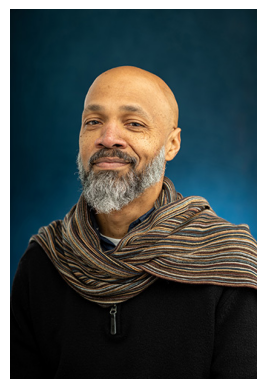


 Composite with edges overlay, dtype=uint8,shape=(500, 333, 3)


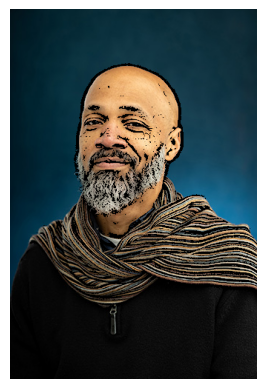


 Posterized image, dtype=uint8,shape=(500, 333, 3)


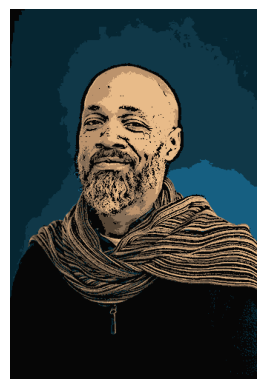


 CONTOURS w/o artifacts, dtype=uint8,shape=(500, 333)


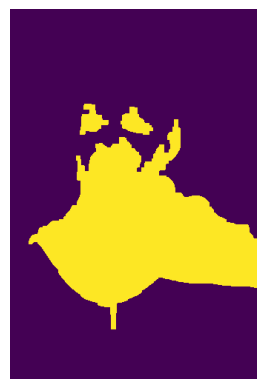


 Result (edges masked to black), dtype=uint8,shape=(500, 333, 3)


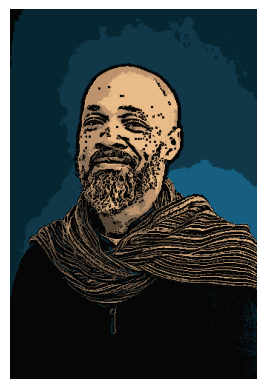


 Filtered edges (Colormap), dtype=uint8,shape=(500, 333, 3)


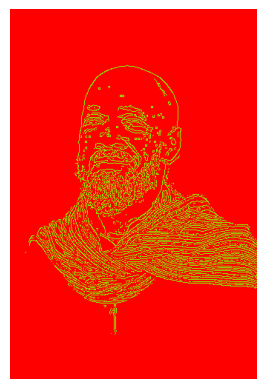


 Blended Final Output, dtype=uint8,shape=(500, 333, 3)


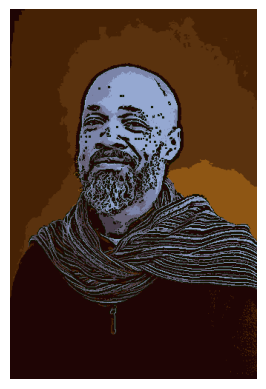

In [59]:
from PIL.Image import composite


img_path = '/content/headshot.jpg' # cv2 starts with image path
img_raw = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

def display_img(img, title=None):

  plt.imshow(img)
  plt.axis('off')
  print(f'\n {title}, dtype={img.dtype},shape={img.shape}')
  plt.show()

def overlay_it(img):
    # Read background
    bg = img
    bg = cv2.cvtColor (bg, cv2.COLOR_BGR2RGB)
    if bg is None:
        print(f"Image not found at: {img_path}")
        return None

    # Convert background image to grayscale for edge detection
    gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 15, 18)

    # White mask (white = 255, transparent areas)
    white_mask = (edges == 255)
    alpha = (~white_mask).astype(np.uint8) * 255  # alpha=255 where edge is black

    # Convert edges to an RGB image
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Stack to make RGBA
    rgba = np.dstack([edges_rgb, alpha])

    # Resize overlay to match background, SHIT...
    if rgba.shape[:2] != bg.shape[:2]:
        rgba = cv2.resize(rgba, (bg.shape[1], bg.shape[0]))

    # Prepare for blending
    foreground = rgba.astype(float) / 255.0
    background = bg.astype(float) / 255.0
    alpha_channel = foreground[..., 3][..., None]

    # Blend!
    composite = alpha_channel * foreground[..., :3] + (1.0 - alpha_channel) * background
    composite = (composite * 255).astype(np.uint8)

    return composite, edges

def posterize_it(img):

  # Removed redundant/incorrect BGR to RGB conversion, as input 'composite' is already RGB.
  pixel_values = img.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  k = 8
  _, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .2), 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)

  posterized_img_local = centers[labels.flatten()]
  posterized_img_local = posterized_img_local.reshape(img.shape)

  return posterized_img_local

def canny1_img(img):
  img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  edges1 = cv2.Canny(img_GRAY, 230, 240)
  kernel = np.ones((1,1), np.uint8)
  dilated_edges = cv2.dilate(edges1, kernel, iterations=1)

  result = img.copy()
  result[dilated_edges !=0] = [0,0,0]

  img_GRAY_blur = cv2.medianBlur(img_GRAY, 3)

  img_filtered = cv2.applyColorMap(dilated_edges, cv2.COLORMAP_WINTER)

  return result, img_filtered

def canny2_img(img):
  # FIX: Use parameter 'img' instead of global 'img_raw'
  # FIX: Assuming 'img' passed is BGR as 'img_raw' is BGR.
  gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(gray_img, threshold1=100, threshold2= 200)

  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5,))
  closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

  opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

  contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  min_length = 100

  output = np.zeros_like(opened)

  for cnt in contours:
    if cv2.arcLength(cnt, False) > min_length:
      cv2.drawContours(output, [cnt], -1, 225, thickness=cv2.FILLED)

  return output # FIX: Return the image with contours drawn, not the contours list

def add_Weighted(img1, img2):

  alpha = 0.9
  beta = 0.1
  gamma = 0

  blended_img = cv2.addWeighted(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB), alpha, img2, beta, gamma) # FIX: Use 'img1' and 'img2' parameters instead of global 'result' and 'img_filtered'

  return blended_img

image = mping.imread('/content/headshot.jpg')
plt.imshow(image)
plt.axis('off')
print(f'Original, dtype={image.dtype},shape={image.shape}\n')
plt.show()


composite, edges = overlay_it(img_raw)



if composite is None:
  raise FileNotFoundError(f'Could not load image from {img_path}')

display_img(composite, "Composite with edges overlay")

# FIX: Call posterize_it and assign its result to posterized_img before its first use
posterized_img = posterize_it(composite)

display_img(posterized_img, 'Posterized image')

c_tours = canny2_img(img_raw)

display_img(c_tours, 'CONTOURS w/o artifacts')

result, img_filtered = canny1_img(posterized_img)

display_img(result, 'Result (edges masked to black)')
display_img(img_filtered, 'Filtered edges (Colormap)')

if result.shape[-1] == 3:
  result_rgb = result
else:
  result_rgb = result[..., :3]

da_pic = add_Weighted(result_rgb, img_filtered)

display_img(da_pic, 'Blended Final Output')
